In [9]:
from pathlib import Path
BASE = Path("/mnt/data/data_bologna_swin_test")   # <- your folder
IFGRAM  = BASE/"inputs/ifgramStack.h5"
TS_H5   = BASE/"timeseries.h5"
VEL_H5  = BASE/"velocity.h5"
W3RA_DIR= BASE/"w3ra"


In [10]:
import os, math, sys

def pretty_size(n):
    units = ["B","KB","MB","GB","TB"]
    i = 0
    while n>=1024 and i<len(units)-1:
        n/=1024; i+=1
    return f"{n:.1f} {units[i]}"

def tree(root: Path, max_depth=2):
    root = Path(root)
    print(root)
    for dirpath, dirnames, filenames in os.walk(root):
        depth = Path(dirpath).relative_to(root).parts
        if len(depth) > max_depth: 
            dirnames[:] = []
            continue
        indent = "  " * len(depth)
        # dirs
        for d in sorted(dirnames):
            print(f"{indent}📁 {d}/")
        # files
        for f in sorted(filenames):
            p = Path(dirpath)/f
            try: sz = p.stat().st_size
            except: sz = 0
            print(f"{indent}📄 {f}  ({pretty_size(sz)})")

tree(BASE, max_depth=2)


/mnt/data/data_bologna_swin_test
📁 inputs/
📁 w3ra/
📄 ERA5.h5  (2.7 GB)
📄 avgSpatialCoh.h5  (42.1 MB)
📄 coherenceSpatialAvg.txt  (7.5 KB)
📄 demErr.h5  (42.1 MB)
📄 geometryGeo.h5  (162.3 MB)
📄 ifgramStack.h5  (13.8 GB)
📄 insar_aligned.h5  (800.0 B)
📄 insar_aligned.nc  (2.7 GB)
📄 insar_aligned_new.nc  (601.1 MB)
📄 insar_velocity_enhanced.nc  (124.9 MB)
📄 maskConnComp.h5  (10.5 MB)
📄 maskTempCoh.h5  (10.5 MB)
📄 mintpy_config.txt  (1.8 KB)
📄 numInvIfgram.h5  (42.1 MB)
📄 region_mask.nc  (41.7 MB)
📄 sg_predicted.nc  (2.6 GB)
📄 smallbaselineApp.cfg  (24.4 KB)
📄 temporalCoherence.h5  (42.1 MB)
📄 timeseries.h5  (6.6 GB)
📄 timeseriesResidual.h5  (6.6 GB)
📄 timeseriesResidual_ramp.h5  (6.6 GB)
📄 timeseries_ERA5.h5  (6.6 GB)
📄 timeseries_ERA5_ramp.h5  (6.6 GB)
📄 timeseries_ERA5_ramp_demErr.h5  (6.6 GB)
📄 velocity.h5  (210.5 MB)
📄 velocityERA5.h5  (210.5 MB)
📄 w3ra_aligned.nc  (412.7 KB)
📄 w3ra_aligned_new.nc  (5.1 GB)
📄 w3ra_on_insar.nc  (26.5 GB)
📄 waterMask.h5  (10.5 MB)
  📄 ERA5.h5  (2.7 GB)
  📄

In [11]:
import h5py, numpy as np, xarray as xr
from datetime import datetime

def _decode_bytes(a):
    if isinstance(a, (np.ndarray, list)):
        return [s.decode() if isinstance(s, (bytes, np.bytes_)) else str(s) for s in a]
    return a.decode() if isinstance(a, (bytes, np.bytes_)) else str(a)

def read_date_list(ts_h5: Path):
    """Return acquisition date strings ['YYYYMMDD', ...] from timeseries.h5."""
    with h5py.File(ts_h5, "r") as f:
        if "date" in f:
            return _decode_bytes(f["date"][...])
        # sometimes stored as attrs
        for k in f.keys():
            if isinstance(f[k], h5py.Dataset) and "date" in f[k].attrs:
                return _decode_bytes(f[k].attrs["date"])
    raise RuntimeError("No acquisition 'date' found in timeseries.h5")

def read_date12_list(ifg_h5: Path):
    """Return interferogram pairs ['YYYYMMDD_YYYYMMDD', ...] if available."""
    keys_try = ["date12List","date12","DATE12","ifgramDateList"]
    with h5py.File(ifg_h5, "r") as f:
        # direct datasets
        for k in keys_try:
            if k in f:
                return _decode_bytes(f[k][...])
        # embedded as dataset attrs (common on 'coherence' or 'unwrapPhase')
        for cand in ["coherence","unwrapPhase","bperp"]:
            if cand in f:
                ds = f[cand]
                for k in keys_try+["DATE12_LIST","date12_list"]:
                    if k in ds.attrs:
                        return _decode_bytes(ds.attrs[k])
    return None  # not fatal for summary


In [12]:
import pandas as pd, numpy as np

# Acquisitions (from timeseries.h5)
dates = read_date_list(TS_H5)
t0, t1 = dates[0], dates[-1]
n_acq = len(dates)

# Interferograms & baselines (from ifgramStack.h5)
with h5py.File(IFGRAM, "r") as f:
    # number of IFGs = size of first dim of coherence (or unwrapPhase)
    for cand in ["coherence","unwrapPhase"]:
        if cand in f:
            n_ifg = f[cand].shape[0]
            break
    else:
        raise RuntimeError("Could not find a 3D ifgram dataset (coherence/unwrapPhase).")

    # perpendicular baselines (shape [n_ifg, n_acq] or [n_ifg])
    bperp = None
    if "bperp" in f:
        bperp = np.array(f["bperp"])
        # collapse to per-ifg magnitude if it's 2-D (MintPy often stores [n_ifg, n_acq])
        if bperp.ndim > 1:
            with np.errstate(invalid='ignore'):
                bperp = np.nanmax(np.abs(bperp), axis=1)
    b_stats = dict(min=None,max=None,mean=None)
    if bperp is not None:
        bb = bperp[np.isfinite(bperp)]
        if bb.size>0:
            b_stats = dict(min=float(np.nanmin(bb)),
                           max=float(np.nanmax(bb)),
                           mean=float(np.nanmean(np.abs(bb))))

# Pair list (optional, if present)
pairs = read_date12_list(IFGRAM)
if pairs is not None:
    # build per-pair df
    d1 = [p.split('_')[0] for p in pairs]
    d2 = [p.split('_')[1] for p in pairs]
    pair_df = pd.DataFrame({"date1":d1, "date2":d2})
else:
    pair_df = None

# Final summary table
summary_df = pd.DataFrame([{
    "AOI": "Emilia–Romagna",
    "Acquisitions": n_acq,
    "First acquisition": pd.to_datetime(t0, format="%Y%m%d"),
    "Last acquisition" : pd.to_datetime(t1, format="%Y%m%d"),
    "Interferograms": n_ifg,
    "Bperp |min|max|mean| (m)": (b_stats["min"], b_stats["max"], b_stats["mean"]),
}])

summary_df


,AOI,Acquisitions,First acquisition,Last acquisition,Interferograms,Bperp |min|max|mean| (m)
0,Emilia–Romagna,156,2017-06-10,2022-10-18,163,"(-96.7686996459961, 149.38890075683594, 45.715..."


In [14]:
import glob
cand = sorted(glob.glob(str(W3RA_DIR/"W3RA_*Sg*EU*.nc"))) or \
       sorted(glob.glob(str(W3RA_DIR/"*Sg*EU*.nc"))) or \
       sorted(glob.glob(str(W3RA_DIR/"*Sg*.nc")))
assert len(cand)>0, "No W3RA Sg *.nc found in /w3ra"
W3RA_SG = Path(cand[0])
print("Using W3RA file:", W3RA_SG.name)

dsw = xr.open_dataset(W3RA_SG)
# time coord can be named many ways; pick the first time-like
tkey = [k for k,v in dsw.coords.items() if "time" in k.lower()][0]
T = pd.to_datetime(dsw[tkey].values)

w3ra_summary = pd.DataFrame([{
    "W3RA file": W3RA_SG.name,
    "Variables": list(dsw.data_vars)[:6],  # preview
    "Grid (lat x lon)": (int(dsw.dims[[k for k in dsw.dims if 'lat' in k.lower()][0]]),
                         int(dsw.dims[[k for k in dsw.dims if 'lon' in k.lower()][0]])),
    "Time steps": len(T),
    "First time": T[0],
    "Last time":  T[-1],
}])
dsw.close()
w3ra_summary


Using W3RA file: W3RA_2010_2024__Sg_EU_2015_2020_anomaly.nc


/mnt/data/tmp/ipykernel_77324/2311692609.py:17: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "Grid (lat x lon)": (int(dsw.dims[[k for k in dsw.dims if 'lat' in k.lower()][0]]),
/mnt/data/tmp/ipykernel_77324/2311692609.py:18: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  int(dsw.dims[[k for k in dsw.dims if 'lon' in k.lower()][0]])),


,W3RA file,Variables,Grid (lat x lon),Time steps,First time,Last time
0,W3RA_2010_2024__Sg_EU_2015_2020_anomaly.nc,[Sg_EU_2015],"(22, 24)",2192,2015-01-02,2021-01-01


In [15]:
# --- Cell 1: setup + inspection + summary tables ---

from pathlib import Path
import os, numpy as np, pandas as pd, xarray as xr, h5py
from datetime import datetime

# ----- paths -----
BASE      = Path("/mnt/data/data_bologna_swin_test")   # <-- change if needed
IFGRAM    = BASE/"inputs/ifgramStack.h5"
TS_H5     = BASE/"timeseries.h5"
VEL_H5    = BASE/"velocity.h5"
W3RA_DIR  = BASE/"w3ra"
OUT_DIR   = BASE/"plots"; OUT_DIR.mkdir(exist_ok=True, parents=True)

# ----- small helpers -----
def pretty_size(n):
    units = ["B","KB","MB","GB","TB"]; i = 0
    while n>=1024 and i<len(units)-1: n/=1024; i+=1
    return f"{n:.1f} {units[i]}"

def tree(root: Path, max_depth=2):
    root = Path(root); print(root)
    for dirpath, dirnames, filenames in os.walk(root):
        depth = Path(dirpath).relative_to(root).parts
        if len(depth) > max_depth:
            dirnames[:] = []
            continue
        indent = "  " * len(depth)
        for d in sorted(dirnames):
            print(f"{indent}📁 {d}/")
        for f in sorted(filenames):
            p = Path(dirpath)/f
            try: sz = p.stat().st_size
            except: sz = 0
            print(f"{indent}📄 {f}  ({pretty_size(sz)})")

def _decode_bytes(a):
    if isinstance(a, (np.ndarray, list)):
        return [s.decode() if isinstance(s, (bytes, np.bytes_)) else str(s) for s in a]
    return a.decode() if isinstance(a, (bytes, np.bytes_)) else str(a)

def read_date_list(ts_h5: Path):
    with h5py.File(ts_h5, "r") as f:
        if "date" in f: return _decode_bytes(f["date"][...])
        # sometimes as attrs on a dataset
        for k in f.keys():
            if isinstance(f[k], h5py.Dataset) and "date" in f[k].attrs:
                return _decode_bytes(f[k].attrs["date"])
    raise RuntimeError("No acquisition 'date' found in timeseries.h5")

def read_date12_list(ifg_h5: Path):
    keys_try = ["date12List","date12","DATE12","ifgramDateList"]
    with h5py.File(ifg_h5, "r") as f:
        for k in keys_try:
            if k in f: return _decode_bytes(f[k][...])
        for cand in ["coherence","unwrapPhase","bperp"]:
            if cand in f:
                ds = f[cand]
                for k in keys_try+["DATE12_LIST","date12_list"]:
                    if k in ds.attrs:
                        return _decode_bytes(ds.attrs[k])
    return None

# ----- 1) print a compact tree -----
print("### Project tree (depth=2) ###")
tree(BASE, max_depth=2)

# ----- 2) MintPy / InSAR summary -----
print("\n### InSAR summary ###")
dates = read_date_list(TS_H5)
t0, t1 = dates[0], dates[-1]
n_acq = len(dates)

with h5py.File(IFGRAM, "r") as f:
    # number of IFGs from a 3D dataset
    for cand in ["coherence","unwrapPhase"]:
        if cand in f:
            n_ifg = f[cand].shape[0]
            break
    else:
        raise RuntimeError("Could not find 3D ifgram dataset (coherence/unwrapPhase).")
    # bperp stats (can be [n_ifg, n_acq] or [n_ifg])
    bperp = f.get("bperp", None)
    if bperp is not None:
        bperp = np.asarray(bperp)
        if bperp.ndim > 1:
            with np.errstate(invalid='ignore'):
                bperp = np.nanmax(np.abs(bperp), axis=1)
        bb = bperp[np.isfinite(bperp)]
        b_stats = dict(min=float(np.nanmin(bb)),
                       max=float(np.nanmax(bb)),
                       mean=float(np.nanmean(np.abs(bb))))
    else:
        b_stats = dict(min=None,max=None,mean=None)

pairs = read_date12_list(IFGRAM)
pair_df = None
if pairs is not None:
    d1 = [p.split('_')[0] for p in pairs]
    d2 = [p.split('_')[1] for p in pairs]
    pair_df = pd.DataFrame({"date1":pd.to_datetime(d1,format="%Y%m%d"),
                            "date2":pd.to_datetime(d2,format="%Y%m%d")}) \
                 .sort_values(["date1","date2"]).reset_index(drop=True)

insar_summary = pd.DataFrame([{
    "AOI": "Emilia–Romagna",
    "Acquisitions": n_acq,
    "First acquisition": pd.to_datetime(t0, format="%Y%m%d"),
    "Last acquisition" : pd.to_datetime(t1, format="%Y%m%d"),
    "Interferograms": n_ifg,
    "Bperp_min_m": b_stats["min"],
    "Bperp_max_m": b_stats["max"],
    "Bperp_mean_abs_m": b_stats["mean"],
}])
display(insar_summary)

# save CSVs
insar_summary.to_csv(BASE/"insar_summary.csv", index=False)
if pair_df is not None:
    pair_df.to_csv(BASE/"pairs.csv", index=False)
    print(f"Saved pairs: {BASE/'pairs.csv'}")
print(f"Saved InSAR summary: {BASE/'insar_summary.csv'}")

# ----- 3) W3RA summary (auto-pick Sg file) -----
import glob
cand = sorted(glob.glob(str(W3RA_DIR/"W3RA_*Sg*EU*.nc"))) or \
       sorted(glob.glob(str(W3RA_DIR/"*Sg*EU*.nc"))) or \
       sorted(glob.glob(str(W3RA_DIR/"*Sg*.nc")))
assert len(cand)>0, "No W3RA Sg *.nc found in /w3ra"
w3ra_sg = Path(cand[0])
dsw = xr.open_dataset(w3ra_sg)

# pick coords
lat_name = [k for k in dsw.dims if "lat" in k.lower()][0]
lon_name = [k for k in dsw.dims if "lon" in k.lower()][0]
time_name= [k for k in list(dsw.coords)+list(dsw.dims) if "time" in k.lower()][0]
T = pd.to_datetime(dsw[time_name].values)

w3ra_summary = pd.DataFrame([{
    "W3RA file": w3ra_sg.name,
    "Grid (lat x lon)": (int(dsw.dims[lat_name]), int(dsw.dims[lon_name])),
    "Time steps": len(T),
    "First time": T[0],
    "Last time":  T[-1],
    "Variables": ", ".join(list(dsw.data_vars)[:6]) + (" ..." if len(dsw.data_vars)>6 else "")
}])
display(w3ra_summary)

w3ra_summary.to_csv(BASE/"w3ra_summary.csv", index=False)
print(f"Saved W3RA summary: {BASE/'w3ra_summary.csv'}")
dsw.close()


### Project tree (depth=2) ###
/mnt/data/data_bologna_swin_test
📁 inputs/
📁 plots/
📁 w3ra/
📄 ERA5.h5  (2.7 GB)
📄 avgSpatialCoh.h5  (42.1 MB)
📄 coherenceSpatialAvg.txt  (7.5 KB)
📄 demErr.h5  (42.1 MB)
📄 geometryGeo.h5  (162.3 MB)
📄 ifgramStack.h5  (13.8 GB)
📄 insar_aligned.h5  (800.0 B)
📄 insar_aligned.nc  (2.7 GB)
📄 insar_aligned_new.nc  (601.1 MB)
📄 insar_velocity_enhanced.nc  (124.9 MB)
📄 maskConnComp.h5  (10.5 MB)
📄 maskTempCoh.h5  (10.5 MB)
📄 mintpy_config.txt  (1.8 KB)
📄 numInvIfgram.h5  (42.1 MB)
📄 region_mask.nc  (41.7 MB)
📄 sg_predicted.nc  (2.6 GB)
📄 smallbaselineApp.cfg  (24.4 KB)
📄 temporalCoherence.h5  (42.1 MB)
📄 timeseries.h5  (6.6 GB)
📄 timeseriesResidual.h5  (6.6 GB)
📄 timeseriesResidual_ramp.h5  (6.6 GB)
📄 timeseries_ERA5.h5  (6.6 GB)
📄 timeseries_ERA5_ramp.h5  (6.6 GB)
📄 timeseries_ERA5_ramp_demErr.h5  (6.6 GB)
📄 velocity.h5  (210.5 MB)
📄 velocityERA5.h5  (210.5 MB)
📄 w3ra_aligned.nc  (412.7 KB)
📄 w3ra_aligned_new.nc  (5.1 GB)
📄 w3ra_on_insar.nc  (26.5 GB)
📄 waterMask

,AOI,Acquisitions,First acquisition,Last acquisition,Interferograms,Bperp_min_m,Bperp_max_m,Bperp_mean_abs_m
0,Emilia–Romagna,156,2017-06-10,2022-10-18,163,-96.7687,149.388901,45.715328


Saved InSAR summary: /mnt/data/data_bologna_swin_test/insar_summary.csv


/mnt/data/tmp/ipykernel_77324/3921902330.py:141: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "Grid (lat x lon)": (int(dsw.dims[lat_name]), int(dsw.dims[lon_name])),


,W3RA file,Grid (lat x lon),Time steps,First time,Last time,Variables
0,W3RA_2010_2024__Sg_EU_2015_2020_anomaly.nc,"(22, 24)",2192,2015-01-02,2021-01-01,Sg_EU_2015


Saved W3RA summary: /mnt/data/data_bologna_swin_test/w3ra_summary.csv


In [ ]:
# --- robust per-year velocity (least-squares with NaN handling) ---

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import FuncFormatter


# 1) slope per time-step using centered time and NaN-safe sums
arr = dsi_var.values  # (time, y, x)
T   = arr.shape[0]
t   = np.arange(T, dtype=np.float32)
tc  = t - t.mean()                     # center time
den = float(np.sum(tc**2)) + 1e-8      # var(t) * T

# cov(t,y): sum(tc * y) along time, ignoring NaNs
num = np.nansum(tc[:, None, None] * arr, axis=0)   # (y, x)
slope_per_step = num / den                         # deformation per time-step

# 2) convert to “per year” using cadence inferred from time coord
dt_days = np.median(np.diff(dsi.time.values).astype('timedelta64[D]').astype(float))
steps_per_year = 365.25 / max(dt_days, 1.0)
vel_insar = slope_per_step * steps_per_year        # (y, x)

# 3) zero-center (optional) and robust symmetric color limits
finite = np.isfinite(vel_insar)
bg = float(np.nanmedian(vel_insar[finite])) if finite.any() else 0.0
vel0 = vel_insar - bg

p2, p98 = np.nanpercentile(vel0, [2, 98])
m = max(abs(p2), abs(p98)) if np.isfinite([p2, p98]).all() else 1.0
vmin, vmax = -m, m
norm = TwoSlopeNorm(vcenter=0.0, vmin=vmin, vmax=vmax)
# --- slim colorbar with cm/a ticks (×100) ---
def _to_cm_per_a(x, pos):
    # your data are in units per year; scale tick labels to cm/a
    return f"{x*100:.0f}"


/mnt/data/tmp/ipykernel_77324/3807974828.py:40: UserWarning: Adding colorbar to a different Figure <Figure size 750x580 with 4 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cb = plt.colorbar(


<Figure size 640x480 with 0 Axes>

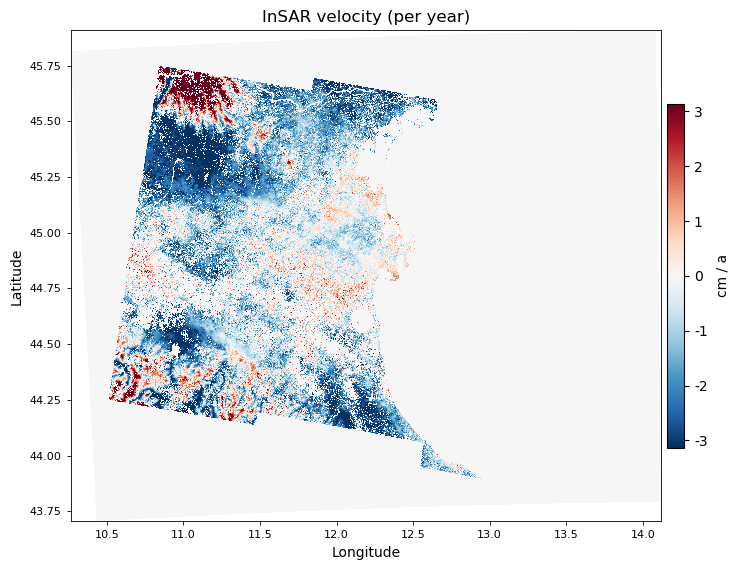

In [32]:
# --- Plot (use existing: vel0, lat, lon, norm) ---
from matplotlib.ticker import FuncFormatter

def to_cm_per_a(x, pos):
    return f"{x*100:.0f}"  # convert m/a -> cm/a on ticks

fig, ax = plt.subplots(figsize=(7.5, 5.8))

if (lat is not None) and (lon is not None):
    im = ax.pcolormesh(
        lon.values, lat.values, vel0,
        cmap="RdBu_r", norm=norm, shading="auto"
    )
    ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
else:
    im = ax.imshow(vel0, cmap="RdBu_r", norm=norm)
    ax.set_xlabel("x"); ax.set_ylabel("y")

# slim colorbar, closer to the plot; ticks in cm/a
cb = fig.colorbar(im, ax=ax, location="right", fraction=0.028, pad=0.01)
cb.formatter = FuncFormatter(to_cm_per_a)
cb.set_label("cm / a", labelpad=6)
cb.update_ticks()

# light styling (optional)
for spine in ax.spines.values():
    spine.set_linewidth(0.6)
ax.tick_params(length=3, width=0.6, labelsize=8)

ax.set_title("InSAR velocity (per year)")
fig.tight_layout()
plt.show()


Using variable: Sg_hat from pred


TypeError: Dimensions of C (2939, 3713) should be one smaller than X(24) and Y(22) while using shading='flat' see help(pcolormesh)

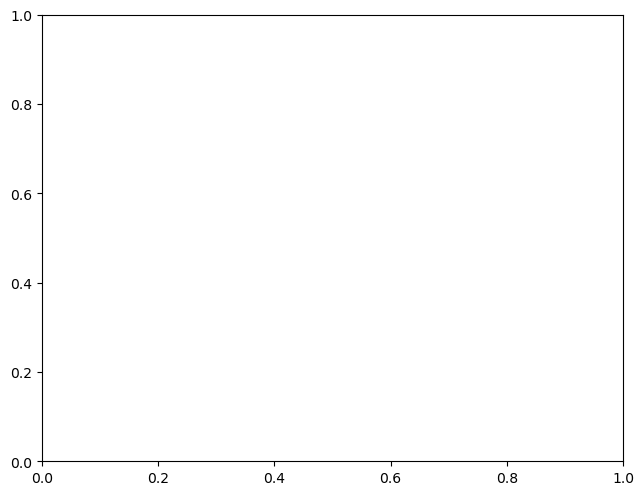

In [36]:
# --- Sg_hat trend (per year) | uses pred / dsw if already defined ---

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import FuncFormatter

# reuse what's already in memory; only open if missing
try:
    pred
except NameError:
    pred = xr.open_dataset(BASE / "sg_predicted.nc")
try:
    dsw
except NameError:
    dsw = xr.open_dataset(BASE / "w3ra_aligned_new.nc")  # only for lat/lon fallback

# pick the Sg_hat variable robustly
cands = [k for k in pred.data_vars if k.lower() in ("sg_hat","sghat","sg","s_g","s_g_hat")]
sg_name = cands[0] if cands else list(pred.data_vars)[0]
sg = pred[sg_name].astype("float32")                    # (time, y, x)
print(f"Using variable: {sg_name} from pred")

# lat/lon if present (prefer from pred)
lat = sg.coords.get("lat") or dsw.coords.get("lat")
lon = sg.coords.get("lon") or dsw.coords.get("lon")

# ---- robust least-squares slope per time-step (NaN safe) ----
arr = sg.values                                         # (T, Y, X)
T   = arr.shape[0]
t   = np.arange(T, dtype=np.float32)
tc  = t - t.mean()                                      # centered time
den = float((tc**2).sum()) + 1e-8

m   = np.nan_to_num(arr, nan=0.0)
num = (tc[:, None, None] * m).sum(axis=0)               # cov(t, y)
slope_per_step = num / den                              # units per time-step

# convert to per-year using actual cadence
dt_days = np.median(np.diff(sg.time.values).astype("timedelta64[D]").astype(float))
steps_per_year = 365.25 / max(dt_days, 1.0)
sg_rate = slope_per_step * steps_per_year               # same units/year as sg

# ---- plotting (slim colorbar, ticks ×100 -> cm/a) ----
finite = np.isfinite(sg_rate)
p2, p98 = np.nanpercentile(sg_rate[finite], [2, 98])
m = max(abs(p2), abs(p98))
vmin, vmax = -m, m
norm = TwoSlopeNorm(vcenter=0.0, vmin=vmin, vmax=vmax)

fig, ax = plt.subplots(figsize=(7.5, 5.8))
if (lat is not None) and (lon is not None):
    im = ax.pcolormesh(lon.values, lat.values, sg_rate, cmap="RdBu_r", norm=norm, shading="auto")
    ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
else:
    im = ax.imshow(sg_rate, cmap="RdBu_r", norm=norm)
    ax.set_xlabel("x"); ax.set_ylabel("y")

ax.set_title("Ŝg trend (per year)")

to_cm_per_a = FuncFormatter(lambda v, pos: f"{v*100:.0f}")  # multiply ticks by 100
cb = plt.colorbar(im, ax=ax, fraction=0.028, pad=0.01)
cb.set_label("cm / a", labelpad=6)
cb.formatter = to_cm_per_a
cb.update_ticks()

plt.tight_layout()
plt.show()


In [ ]:

# 4) plot (pcolormesh if lat/lon are present)
plt.figure(figsize=(7.5, 5.8))
if (lat is not None) and (lon is not None):
    im = plt.pcolormesh(lon.values, lat.values, vel0, cmap='RdBu_r', norm=norm, shading='auto')
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
else:
    im = plt.imshow(vel0, cmap='RdBu_r', norm=norm)
    plt.xlabel("x"); plt.ylabel("y")

cb = plt.colorbar(im)
cb.set_label("deformation units / year (zero-centered)")
plt.title("InSAR velocity (per year)")
plt.tight_layout()
plt.show()



In [18]:
IFGRAM      = f"{BASE}/inputs/ifgramStack.h5"   # as before
NUMINV      = f"{BASE}/numInvIfgram.h5"
TS_H5       = f"{BASE}/timeseries.h5"


In [19]:
import h5py
import numpy as np
import pandas as pd
from datetime import datetime

def _decode_bytes_arr(a):
    if isinstance(a, np.ndarray) and a.dtype.kind in ("S","O"):
        try:
            return np.array([s.decode() if isinstance(s, (bytes, np.bytes_)) else str(s) for s in a])
        except Exception:
            return a.astype(str)
    return a

def _to_dt(s):  # 'YYYYMMDD' -> datetime
    return datetime.strptime(s, "%Y%m%d")

def load_pairs_df() -> pd.DataFrame:
    """
    Try to read date pairs (and bperp if available) from:
    1) ifgramStack.h5  (date12List / DATE12 / ifgramDateList, plus bperp)
    2) numInvIfgram.h5 (dataset 'date12' or attribute variants)
    3) timeseries.h5   (attributes DATE12_LIST)  -- rare
    Returns DataFrame with columns: ['date1','date2','bperp'] (bperp optional).
    """
    candidates = []

    # --- 1) ifgramStack.h5 ---
    try:
        with h5py.File(IFGRAM, "r") as f:
            # look for date-pair arrays in datasets or file attrs
            keys = set(f.keys()) | set(f.attrs.keys())
            # dataset candidates
            for k in ["date12List", "DATE12", "ifgramDateList"]:
                if k in f:
                    arr = _decode_bytes_arr(f[k][...])
                    candidates.append(("ifgram", arr))
                    break
            # attr candidates
            if not candidates:
                for k in ["date12List", "DATE12", "ifgramDateList"]:
                    if k in f.attrs:
                        arr = _decode_bytes_arr(f.attrs[k])
                        candidates.append(("ifgram_attr", arr))
                        break
            # bperp if present
            bperp = None
            if "bperp" in f:
                bperp = np.asarray(f["bperp"][...], dtype=float)
    except Exception:
        bperp = None

    # --- 2) numInvIfgram.h5 ---
    if not candidates:
        try:
            with h5py.File(NUMINV, "r") as f:
                # common patterns: dataset 'date12' of shape (N,2), or a flat list under attr
                if "date12" in f:
                    arr = _decode_bytes_arr(f["date12"][...])
                    # normalize to flat list of "YYYYMMDD_YYYYMMDD"
                    if arr.ndim == 2 and arr.shape[1] == 2:
                        flat = np.array([f"{a}_{b}" for a, b in arr])
                    else:
                        flat = arr.reshape(-1)
                    candidates.append(("numinv", flat))
                else:
                    for k in ["date12", "date12List", "DATE12"]:
                        if k in f.attrs:
                            arr = _decode_bytes_arr(f.attrs[k])
                            candidates.append(("numinv_attr", arr))
                            break
        except Exception:
            pass

    # --- 3) timeseries.h5 (last resort) ---
    if not candidates:
        try:
            with h5py.File(TS_H5, "r") as f:
                for k in ["DATE12_LIST", "date12List", "DATE12"]:
                    if k in f.attrs:
                        arr = _decode_bytes_arr(f.attrs[k])
                        candidates.append(("ts_attr", arr))
                        break
        except Exception:
            pass

    if not candidates:
        raise RuntimeError("No date12 list found in ifgramStack.h5, numInvIfgram.h5, or timeseries.h5.")

    source, arr = candidates[0]
    # normalize to list of pairs
    if isinstance(arr, np.ndarray):
        arr = arr.tolist()
    arr = [s if isinstance(s, str) else str(s) for s in arr]
    # strings can be "YYYYMMDD_YYYYMMDD" or two tokens separated by space/comma
    d1, d2 = [], []
    for s in arr:
        tok = s.replace(",", "_").replace(" ", "_").split("_")
        if len(tok) >= 2:
            d1.append(tok[0]); d2.append(tok[1])

    df = pd.DataFrame({"date1": d1, "date2": d2})
    # attach bperp if we grabbed it from ifgramStack
    if "bperp" in locals() and bperp is not None and len(bperp) == len(df):
        df["bperp"] = bperp
    return df


IndexError: index 0 is out of bounds for axis 0 with size 0

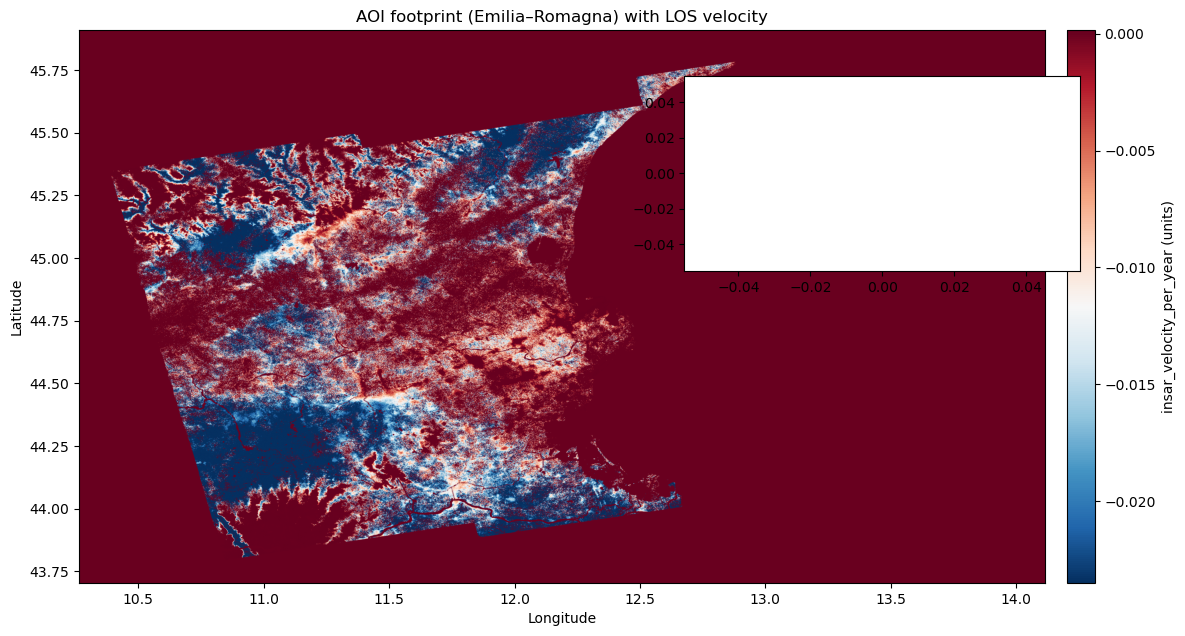

In [20]:
# ---------- load data ----------
pairs_df = load_pairs_df()

# ---------- figure ----------
fig = plt.figure(figsize=(12, 6.5), constrained_layout=False)
gs = fig.add_gridspec(nrows=1, ncols=1, left=0.07, right=0.98, bottom=0.10, top=0.95)
ax = fig.add_subplot(gs[0])

# percentile clip for clean footprint
valid = np.isfinite(V)
vmin = np.nanpercentile(V[valid], 5)
vmax = np.nanpercentile(V[valid], 95)

im = ax.imshow(V, extent=[lon.min(), lon.max(), lat.min(), lat.max()],
               origin="lower", cmap="RdBu_r", vmin=vmin, vmax=vmax)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("AOI footprint (Emilia–Romagna) with LOS velocity")

# colorbar
cb = fig.colorbar(im, ax=ax, fraction=0.045, pad=0.02)
cb.set_label(f"{var_name} (units)")

# ---------- inset: pair network ----------
# build acquisition list from pairs_df
acq = pd.DatetimeIndex(sorted(pd.unique(pairs_df[["date1","date2"]].values.ravel())))
idx = {d: i for i, d in enumerate(acq)}
y0 = np.arange(len(pairs_df)) * 0  # all on same y=0 line; we draw horizontal segments across the timeline

# inset axes (relative to main)
axg = fig.add_axes([0.62, 0.58, 0.33, 0.30])  # [left, bottom, width, height] in figure frac
for (d1, d2) in pairs_df[["date1","date2"]].itertuples(index=False, name=None):
    i, j = idx[pd.Timestamp(d1)], idx[pd.Timestamp(d2)]
    axg.plot([i, j], [0, 0], "-k", lw=0.35, alpha=0.9)

# scatter acquisitions
axg.scatter(range(len(acq)), np.zeros(len(acq)), s=8)

# x ticks (sparse)
tick_idx = np.linspace(0, len(acq)-1, 5, dtype=int)
tick_lbl = [acq[i].strftime("%Y-%m") for i in tick_idx]
axg.set_xticks(tick_idx)
axg.set_xticklabels(tick_lbl, rotation=0, fontsize=8)
axg.set_yticks([])
axg.set_xlim(-1, len(acq))
axg.set_title("SBAS/stack pair network", fontsize=10)

# ---------- save ----------
fig.tight_layout()
fig.savefig(OUT_PNG, dpi=350)
print(f"Saved: {OUT_PNG}")
plt.show()


In [2]:
# --- CONFIG --- 
BASE = "/mnt/data/data_bologna_swin_test"   # <- your folder shown in the screenshots
IFGRAM = f"{BASE}/inputs/ifgramStack.h5"
W3RA_NC = f"{BASE}/w3ra/W3RA_Sg_EU.nc"      # or the specific file you want (e.g., Sg_EU.nc)

# --- IMPORTS ---
import os, sys, math, textwrap, json, h5py
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime


In [3]:
def tree(root, max_depth=2):
    root = os.path.abspath(root)
    print(root)
    for dirpath, dirnames, filenames in os.walk(root):
        depth = dirpath[len(root):].count(os.sep)
        if depth > max_depth: 
            # don’t descend further
            dirnames[:] = []
            continue
        indent = "  " * depth
        print(f"{indent}{os.path.basename(dirpath) or '.'}/")
        for d in sorted(dirnames):
            print(f"{indent}  {d}/")
        for f in sorted(filenames):
            print(f"{indent}  {f}")

tree(BASE, max_depth=2)


/mnt/data/data_bologna_swin_test
data_bologna_swin_test/
  inputs/
  w3ra/
  ERA5.h5
  avgSpatialCoh.h5
  coherenceSpatialAvg.txt
  demErr.h5
  geometryGeo.h5
  ifgramStack.h5
  insar_aligned.h5
  insar_aligned.nc
  insar_aligned_new.nc
  insar_velocity_enhanced.nc
  maskConnComp.h5
  maskTempCoh.h5
  mintpy_config.txt
  numInvIfgram.h5
  region_mask.nc
  sg_predicted.nc
  smallbaselineApp.cfg
  temporalCoherence.h5
  timeseries.h5
  timeseriesResidual.h5
  timeseriesResidual_ramp.h5
  timeseries_ERA5.h5
  timeseries_ERA5_ramp.h5
  timeseries_ERA5_ramp_demErr.h5
  velocity.h5
  velocityERA5.h5
  w3ra_aligned.nc
  w3ra_aligned_new.nc
  w3ra_on_insar.nc
  waterMask.h5
  inputs/
    ERA5.h5
    geometryGeo.h5
    ifgramStack.h5
  w3ra/
    S0_EU.nc
    Sd_EU.nc
    Sg_EU.nc
    Sg_EU.nc.aux.xml
    Sr_EU.nc
    Ss_EU.nc
    Ssnow_EU.nc
    Stot_EU.nc
    W3RA_2010_2024.nc
    W3RA_2010_2024.nc.aux.xml
    W3RA_2010_2024_.cpg
    W3RA_2010_2024_.dbf
    W3RA_2010_2024_.nc
    W3RA_2010_202

Panel (a): AOI & pair network

AOI map: base = any of your rasters (e.g., insar_velocity_enhanced.nc) to draw the footprint.
Pair graph inset: use MintPy’s ifgramStack.h5 to extract date pairs.

In [6]:
import h5py
from pathlib import Path

def walk_h5(fn: Path, max_attr=10):
    print("\nHDF5 file:", fn)
    if not fn.exists():
        print("  (missing)")
        return
    with h5py.File(fn, "r") as f:
        def _show(name, obj):
            if isinstance(obj, h5py.Dataset):
                print(f"  [DATASET] {name:35s} shape={obj.shape} dtype={obj.dtype}")
                # show a few attributes commonly used by MintPy
                if obj.attrs:
                    keys = list(obj.attrs.keys())[:max_attr]
                    kv = {k: obj.attrs[k] for k in keys}
                    print("           attrs:", kv)
            elif isinstance(obj, h5py.Group):
                print(f"  [GROUP]   {name}")
        f.visititems(_show)


In [7]:
import xarray as xr
import numpy as np

def inspect_w3ra_nc(path: Path):
    print("\n---", path.name, "---")
    if not path.exists():
        print("  (missing)")
        return
    ds = xr.open_dataset(path)
    try:
        #print("  dims:", {k:int(v) for k,v in ds.dims.items()})
        print("  dims:", dict(ds.sizes)) # more concise
        print("  data vars (first 15):", list(ds.data_vars)[:15])
        # Try to show time coordinates if present under common names
        if "time" in ds:
            t = ds["time"].values
            print(f"  time len={len(t)}  first={t[:3]}  last={t[-3:]}")
        else:
            # Some stitched files have per-year dims (e.g., time_2010, time_2011, ...)
            year_dims = [k for k in ds.dims if k.startswith("time_")]
            if year_dims:
                print("  multi-year time dims:", year_dims[:10], "...")
                for k in year_dims[:3]:
                    v = ds[k].values
                    print(f"   {k}: len={len(v)} first={v[:2]} last={v[-2:]}")
    finally:
        ds.close()


In [8]:
walk_h5(Path(IFGRAM))
inspect_w3ra_nc(Path(W3RA_NC))  


HDF5 file: /mnt/data/data_bologna_swin_test/inputs/ifgramStack.h5
  [DATASET] bperp                               shape=(163,) dtype=float32
  [DATASET] coherence                           shape=(163, 2939, 3713) dtype=float32
           attrs: {'MODIFICATION_TIME': '1755583395.7413783'}
  [DATASET] date                                shape=(163, 2) dtype=|S8
  [DATASET] dropIfgram                          shape=(163,) dtype=bool
  [DATASET] unwrapPhase                         shape=(163, 2939, 3713) dtype=float32
           attrs: {'MODIFICATION_TIME': '1755583116.3974059'}

--- W3RA_Sg_EU.nc ---
  dims: {'time_2010': 365, 'lat': 22, 'lon': 24, 'time_2011': 365, 'time_2012': 366, 'time_2013': 365, 'time_2014': 365, 'time_2015': 365, 'time_2016': 366, 'time_2017': 365, 'time_2018': 365, 'time_2019': 365, 'time_2020': 366, 'time_2021': 365, 'time_2022': 365, 'time_2023': 365, 'time_2024': 213}
  data vars (first 15): ['Sg_EU_2010', 'Sg_EU_2011', 'Sg_EU_2012', 'Sg_EU_2013', 'Sg_EU_2014'